In [1]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
from pandas import read_csv, read_feather
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time
import emcee
import corner


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [2]:
def guess_texp(lc, sigma=1):
    """
    Guess texp (explosion time) for Ibc SNe as the time of peak flux,
    ignoring any flux points more than `sigma` above the mean.

    Parameters:
        lc: astropy Table with 'time' and 'flux' columns
        sigma: threshold for outlier rejection (default 5)

    Returns:
        texp_guess: float, estimated explosion time (time of peak flux)
    """
    times = np.array(lc['time'])
    fluxes = np.array(lc['flux'])
    mean = np.mean(fluxes)
    std = np.std(fluxes)
    mask = fluxes < (mean + sigma * std)
    if np.any(mask):
        peak_idx = np.argmax(fluxes[mask])
        max_time = times[mask][peak_idx]
    else:
        max_time = times[np.argmax(fluxes)]
    if max_time < 15:
        texp_guess = 0
    elif max_time > 35:
        texp_guess = 20
    else:
        texp_guess = max_time - 15
    return texp_guess


In [3]:
class ArnettSource(sncosmo.Source):

    _param_names = ['texp', 'mej', 'fni', 'vej']
    param_names = ['texp', 'mej', 'fni', 'vej']

    param_names_latex = ['t_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift,  params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # print("hello")
        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
 
        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        # print(np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni))
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)
        # print(np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco))
        # print("a")
        # print(td)
        # print(t_to_integrate)
        # print("1", integrand1)
        # print("2", integrand2)


        # evaluate np.exp(-t_to_integrate**2 / td**2) and set to zero if too small

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        # print("b")
        # print(dense_luminosities)
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        # print("c")
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points
        # print(luminosities)
        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        # gind = (temperature < tfloor) | np.isnan(temperature)
        # temperature = np.nan_to_num(temperature)
        # notgind = np.invert(gind)
        # temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)

                # Set temperature floor before radius calculation
        temperature = np.maximum(temperature, tfloor)
        
        # print(temperature)

        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        # fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        
        fluxes = self._blackbody_flux(temperature, radius, wvs / (1 + redshift)) # this is a luminosity density

        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3
        fluxes[t < 0,:] = 0.* u.kg *u.m / u.s**3
        fluxes[np.isnan(fluxes)] = 0.* u.kg *u.m / u.s**3

        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density / (1 + redshift)


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [4]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

# bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# # zeropoints from https://smtn-002.lsst.io/
# zeropoints = [28.51, 28.36, 28.17, 27.78]
# # LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
# sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# # LSST observing parameters (from official LSST specs)
# exptime = 30.0  # seconds per visit (2x15s exposures)
# pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
# aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
# read_noise = 8.8  # electrons per pixel per exposure
# dark_current = 0.2  # electrons per pixel per second
# num_bands = len(bands)

# # Convert sky brightness to sky noise (electrons/pixel/second)
# # Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# # Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# # For now, using approximate values - these should be calculated more precisely
# sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


# ia_obs = Table({'time': list(time_points) * num_bands,
#              'band': np.repeat(bands, num_points),
#             'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
#              'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
#              'exptime': exptime * np.ones(num_points*num_bands),
#              'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
#              'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
#              'read_noise': read_noise * np.ones(num_points*num_bands),
#              'dark_current': dark_current * np.ones(num_points*num_bands)})

# ibc_obs = Table({'time': list(time_points) * num_bands,
#              'band': np.repeat(bands, num_points),
#             'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
#              'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
#              'exptime': exptime * np.ones(num_points*num_bands),
#              'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
#              'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
#              'read_noise': read_noise * np.ones(num_points*num_bands),
#              'dark_current': dark_current * np.ones(num_points*num_bands)})



In [5]:
def fit_ibc(true_z, lcs, texp_guess = None, mej=3, fni=0.05, vej=15000):
    if texp_guess is None:
        texp_guess = guess_texp(lcs[0], sigma=1)

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[texp_guess, mej, fni, vej]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(0,20), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[10, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0,20), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [6]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [7]:
def fit_ia(true_z, lcs):    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [8]:
import os
import re

# Read the ibc_data.csv file to get redshift and Av for each object
ibc_data = pd.read_csv("ibc_data.csv")

# Create a lookup dictionary from ZTFID to (redshift, A_V)
# Skip rows with invalid redshift values (e.g., '-')
ibc_lookup = {}
for _, row in ibc_data.iterrows():
    try:
        redshift = float(row['redshift'])
        av = float(row['A_V'])
        ibc_lookup[row['ZTFID']] = {'redshift': redshift, 'A_V': av}
    except (ValueError, TypeError):
        # Skip rows with invalid redshift or A_V values
        pass

def get_object_data_from_directory(directory_path):
    """
    Extract object names from CSV filenames and match to redshift/Av from ibc_data.csv.
    
    Expected filename format: "ZTF18abfzhct_SN-Ic_0.04_bts.csv"
    where ZTF18abfzhct is the object name.
    
    Parameters:
    -----------
    directory_path : str
        Path to directory containing the CSV files
        
    Returns:
    --------
    tuple : (redshift_dict, av_dict) - two dictionaries indexed by filename
    """
    redshift_dict = {}
    av_dict = {}
    
    # Get all CSV files in the directory
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('_bts.csv')]
    
    for filename in csv_files:
        # Extract object name (first part before the first underscore)
        object_name = filename.split('_')[0]
        
        if object_name in ibc_lookup:
            redshift_dict[filename] = ibc_lookup[object_name]['redshift']
            av_dict[filename] = ibc_lookup[object_name]['A_V']
        else:
            print(f"Warning: {object_name} from {filename} not found in ibc_data.csv")
    
    return redshift_dict, av_dict

# Use the function
directory_path = "ibc_sims_to_fit"
redshift_dict, av_dict = get_object_data_from_directory(directory_path)

# Display results
print(f"Matched {len(redshift_dict)} files to ibc_data.csv:\n")
for filename in sorted(redshift_dict.keys(), key=lambda x: redshift_dict[x]):
    print(f"{filename}: z = {redshift_dict[filename]}, A_V = {av_dict[filename]}")

Matched 260 files to ibc_data.csv:

ZTF23aadaxfn_SN-Ic_0.0023_bts.csv: z = 0.0023, A_V = 0.045
ZTF24abyaspl_SN-Ic_0.00266_bts.csv: z = 0.00266, A_V = 0.158
ZTF19aatesgp_SN-Ib_0.0043_bts.csv: z = 0.0043, A_V = 0.072
ZTF20aaelulu_SN-Ic_0.0052_bts.csv: z = 0.0052, A_V = 0.072
ZTF20aavzffg_SN-Ib_0.00524_bts.csv: z = 0.00524, A_V = 0.433
ZTF22aadqlhy_SN-Ib-pec_0.006_bts.csv: z = 0.006, A_V = 0.269
ZTF21aawmdxw_SN-Ib_0.00611_bts.csv: z = 0.00611, A_V = 0.139
ZTF21aaqhhfu_SN-Ib_0.00621_bts.csv: z = 0.00621, A_V = 0.097
ZTF20acpjqxp_SN-Ib-pec_0.0065_bts.csv: z = 0.0065, A_V = 0.158
ZTF23aawzdxd_SN-Ib_0.007_bts.csv: z = 0.007, A_V = 0.086
ZTF20adadrhw_SN-Ic_0.0075_bts.csv: z = 0.0075, A_V = 0.099
ZTF21aaaubig_SN-Ic_0.00934_bts.csv: z = 0.00934, A_V = 0.067
ZTF21abcgaln_SN-Ic_0.00965_bts.csv: z = 0.00965, A_V = 0.261
ZTF22aadoihx_SN-Ib_0.01041_bts.csv: z = 0.01041, A_V = 0.046
ZTF23abhyxpr_SN-Ib_0.01189_bts.csv: z = 0.01189, A_V = 0.107
ZTF22aasxgjp_SN-Ic-pec_0.012_bts.csv: z = 0.012, A_V = 0.05

In [9]:
redshift_dict

{'ZTF23abbskff_SN-Ic_0.02923_bts.csv': 0.02923,
 'ZTF18abeyqpr_SN-Ic_0.0472_bts.csv': 0.0472,
 'ZTF20abbpkng_SN-Ib_0.0374_bts.csv': 0.0374,
 'ZTF18abecbks_SN-Ic_0.03048_bts.csv': 0.03048,
 'ZTF21acjxzsa_SN-Ic_0.041_bts.csv': 0.041,
 'ZTF24abyaspl_SN-Ic_0.00266_bts.csv': 0.00266,
 'ZTF21aceehxt_SN-Ib_0.01309_bts.csv': 0.01309,
 'ZTF23absgcqv_SN-Ic_0.057_bts.csv': 0.057,
 'ZTF23aapbrrq_SN-Ib_0.015_bts.csv': 0.015,
 'ZTF24aazmqbf_SN-Ic_0.0293_bts.csv': 0.0293,
 'ZTF20abysxbk_SN-Ib_0.0254_bts.csv': 0.0254,
 'ZTF20abvvnqh_SN-Ic_0.0369_bts.csv': 0.0369,
 'ZTF19aavoweu_SN-Ic_0.0359_bts.csv': 0.0359,
 'ZTF18abdffeo_SN-Ibc_0.01479_bts.csv': 0.01479,
 'ZTF24abwmzop_SN-Ibc_0.0168_bts.csv': 0.0168,
 'ZTF19aatheus_SN-Ic_0.01836_bts.csv': 0.01836,
 'ZTF23aajfdxf_SN-Ib_0.045_bts.csv': 0.045,
 'ZTF24abnafgr_SN-Ic_0.0387_bts.csv': 0.0387,
 'ZTF19aarfyvc_SN-Ic_0.09_bts.csv': 0.09,
 'ZTF20abvquuo_SN-Ib_0.03_bts.csv': 0.03,
 'ZTF22abkabeh_SN-Ib_0.028_bts.csv': 0.028,
 'ZTF20aanvmdt_SN-Ib_0.037_bts.csv': 0

In [10]:
ZP = 25.0
ZPSYS = 'ab'

def mag_to_bandflux(mag, zp=ZP):
    return 10**(-0.4 * (mag - zp))
                
def magerr_to_fluxerr(mag, magerr, zp=ZP):
    f = mag_to_bandflux(mag, zp)
    return f * np.log(10) * 0.4 * magerr

def read_ibc_csv(filename):
    df = pd.read_csv("ibc_sims_to_fit/" + filename)
    # Example: convert to astropy Table if needed
    tab = Table.from_pandas(df)
    tab['flux'] = mag_to_bandflux(tab['mag'])
    tab['fluxerr'] = magerr_to_fluxerr(tab['mag'], tab['dmag'])
    tab['zp'] = ZP * np.ones_like(tab['flux'])
    tab['zpsys'] = np.array([ZPSYS] * len(tab), dtype=str)
    tab['band'] = np.array(['ztf' + f for f in tab['filter']], dtype=str)
    tab['time'] = tab['mjd'] - np.min(tab['mjd'])
    tab.remove_column('mjd')
    tab.remove_column('filter')
    return tab

csv_path = "ZTF18abfzhct_SN-Ic_0.04_bts.csv"
this_redshift = redshift_dict[csv_path]
this_av = av_dict[csv_path]
ibc_lc_table = read_ibc_csv(csv_path)
print(this_redshift, this_av)

0.04 0.049


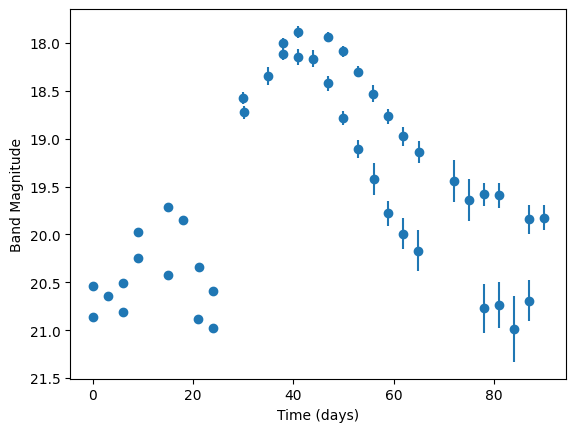

In [11]:
plt.errorbar(ibc_lc_table['time'], ibc_lc_table['mag'], yerr=ibc_lc_table['dmag'], linestyle='none', marker = 'o')
plt.xlabel("Time (days)")
plt.ylabel("Band Magnitude")
plt.gca().invert_yaxis()

In [12]:
guess_texp(ibc_lc_table)

20

In [13]:
def fit_ia_w_dust(true_z, true_av, lcs):    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    dust = sncosmo.CCM89Dust()   # MW extinction law
    R_V = 3.1
    mwebv = true_av / R_V

    this_ia_model = sncosmo.Model(source=ia_source, 
                                  effects=[dust],
                                  effect_names=['mw'],
                                  effect_frames=['obs'])

    this_ia_model.set(z = true_z, mwebv=mwebv)

    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [14]:
this_redshift, this_av

(0.04, 0.049)

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/plotting.py:429: RuntimeWarning: divide by zero encountered in divide
  fluxpulls = (flux - mflux) / fluxerr


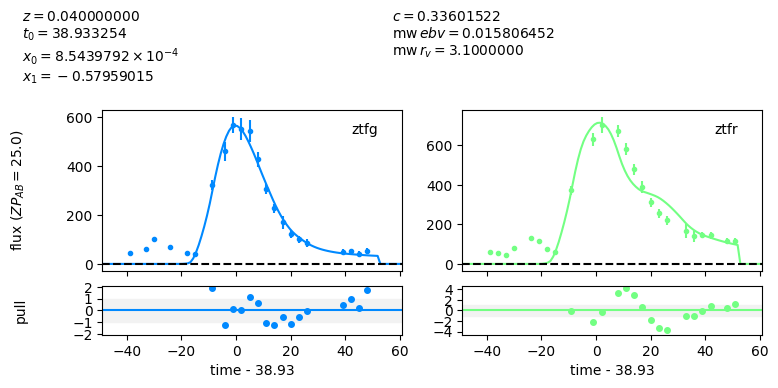

In [15]:
# result, fitted_model = fit_ia(this_redshift, [ibc_lc_table])
result, fitted_model = fit_ia_w_dust(this_redshift, this_av, [ibc_lc_table])
sncosmo.plot_lc(ibc_lc_table, model=fitted_model);

In [16]:
def fit_ibc_w_dust(true_z, true_av, lcs, texp_guess=None, mej=3, fni=0.05, vej=15000):
    if texp_guess is None:
        texp_guess = guess_texp(lcs[0], sigma=1)

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[texp_guess, mej, fni, vej])
    
    dust = sncosmo.CCM89Dust()   # MW extinction law
    R_V = 3.1
    mwebv = true_av / R_V

    arnett_model = sncosmo.Model(source=arnett_source,
                                 effects=[dust],
                                 effect_names=['mw'],
                                 effect_frames=['obs'])
    arnett_model.set(mwebv=mwebv)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(0,20), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[10, 0.5, 0.1, 20000])
        arnett_model = sncosmo.Model(source=arnett_source,
                                     effects=[dust],
                                     effect_names=['mw'],
                                     effect_frames=['obs'])
        arnett_model.set(mwebv=mwebv)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0,20), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    return result, fitted_model

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


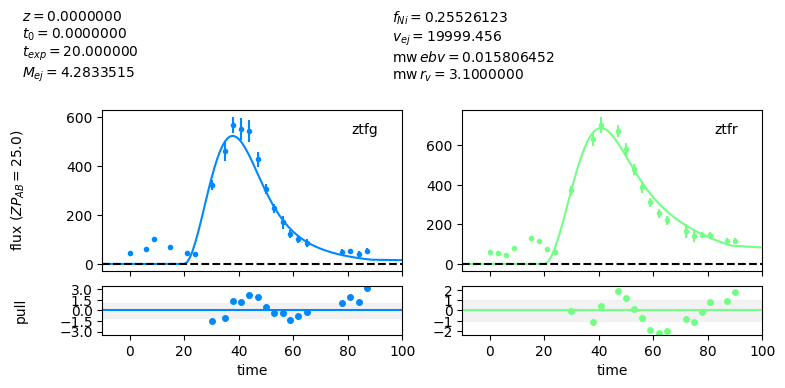

In [17]:
# result, fitted_model = fit_ibc(this_redshift, [ibc_lc_table])
result, fitted_model = fit_ibc_w_dust(this_redshift, this_av, [ibc_lc_table])
sncosmo.plot_lc(ibc_lc_table, model=fitted_model);

In [18]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [24]:
# Fit all light curves in ibc_sims_to_fit/ with both Ia and Ibc models
sn_objects = []
failed_files = []

for filename in redshift_dict.keys():
    try:
        # Read the light curve
        lc_table = read_ibc_csv(filename)
        
        # Get redshift and A_V for this object
        this_redshift = redshift_dict[filename]
        this_av = av_dict[filename]
        
        # Extract the true class from filename (e.g., "ZTF18abfzhct_SN-Ic_0.04_bts.csv" -> "SN Ic")
        parts = filename.split('_')
        true_class = parts[1].replace('-', ' ')  # "SN-Ic" -> "SN Ic"
        
        # Fit with both models
        ia_result, ia_fitted_model = fit_ia_w_dust(this_redshift, this_av, [lc_table])
        ibc_result, ibc_fitted_model = fit_ibc_w_dust(this_redshift, this_av, [lc_table])

        # Plot fits
        # sncosmo.plot_lc(lc_table, model=ibc_fitted_model)
        # sncosmo.plot_lc(lc_table, model=ia_fitted_model)
        # plt.show()


        # Create real_SN object and store fit results
        sn_obj = real_SN(true_class, this_redshift)
        sn_obj.fit_as_ia(sncosmo.flatten_result(ia_result))
        sn_obj.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        sn_objects.append(sn_obj)
        
        print(f"Successfully fit {filename}")
        
    except Exception as e:
        print(f"Failed to fit {filename}: {e}")
        failed_files.append((filename, str(e)))

print(f"\nSuccessfully fit {len(sn_objects)} out of {len(redshift_dict)} light curves")
print(f"Failed: {len(failed_files)}")

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abbskff_SN-Ic_0.02923_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abeyqpr_SN-Ic_0.0472_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abbpkng_SN-Ib_0.0374_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abecbks_SN-Ic_0.03048_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21acjxzsa_SN-Ic_0.041_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abyaspl_SN-Ic_0.00266_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aceehxt_SN-Ib_0.01309_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23absgcqv_SN-Ic_0.057_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarnin

Trying again...
Failed to fit ZTF23aapbrrq_SN-Ib_0.015_bts.csv: `y` must contain only finite values.
Successfully fit ZTF24aazmqbf_SN-Ic_0.0293_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abysxbk_SN-Ib_0.0254_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abvvnqh_SN-Ic_0.0369_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aavoweu_SN-Ic_0.0359_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abdffeo_SN-Ibc_0.01479_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abwmzop_SN-Ibc_0.0168_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aatheus_SN-Ic_0.01836_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aajfdxf_SN-Ib_0.045_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abnafgr_SN-Ic_0.0387_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aarfyvc_SN-Ic_0.09_bts.csv
Failed to fit ZTF20abvquuo_SN-Ib_0.03_bts.csv: result is NaN for [ 0.03 nan nan nan nan 0.21 3.1 ]


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22abkabeh_SN-Ib_0.028_bts.csv
Trying again...
Failed to fit ZTF20aanvmdt_SN-Ib_0.037_bts.csv: `x` must be strictly increasing sequence.


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aajakys_SN-Ic_0.0328_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aalfsqm_SN-Ic_0.0305_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abvkmgw_SN-Ib_0.03847_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aaemnzd_SN-Ic_0.037_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abtkjfw_SN-Ic_0.01744_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abngbrl_SN-Ib_0.03_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18aczqzrj_SN-Ic_0.0429_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aaeczdw_SN-Ib_0.02967_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18adasisj_SN-Ic_0.034_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aaaosoq_SN-Ic_0.03151_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19adcfsad_SN-Ib_0.0255_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abpwtde_SN-Ibc_0.04_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19acmelor_SN-Ib_0.02661_bts.csv
Failed to fit ZTF24aacjcwl_SN-Ic_0.0268_bts.csv: result is NaN for [ 0.0268 nan nan nan nan 0.162581 3.1 ]


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22abllclb_SN-Ic_0.02117_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aaqwfqe_SN-Ib_0.0211_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aatunnt_SN-Ib_0.04_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19ackjjwf_SN-Ib_0.01619_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF25aaafxvn_SN-Ibc_0.05_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aceqvhl_SN-Ic_0.028_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abxpoxd_SN-Ic_0.02208_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abauylg_SN-Ic_0.044_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24ablsxza_SN-Ic_0.02872_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20acpzaoa_SN-Ib_0.03_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24absznoi_SN-Ic_0.04095_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22absibqa_SN-Ic_0.01441_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abiwzzc_SN-Ic_0.05_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarnin

Trying again...
Successfully fit ZTF19abtsnyy_SN-Ic_0.04_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abnpoqp_SN-Ib_0.036_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abdoior_SN-Ic_0.047_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarnin

Trying again...
Failed to fit ZTF23aawzdxd_SN-Ib_0.007_bts.csv: `y` must contain only finite values.


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21acdxhuv_SN-Ib_0.015_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abqqrgy_SN-Ib_0.0296_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abccaue_SN-Ib_0.03975_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarnin

Trying again...
Failed to fit ZTF21aaxtctv_SN-Ic_0.01356_bts.csv: `y` must contain only finite values.
Successfully fit ZTF19aamsetj_SN-Ic_0.02751_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aceqjqw_SN-Ic_0.0265_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aaztbct_SN-Ic_0.023_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aaurfnl_SN-Ic_0.0336_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abzgggz_SN-Ic_0.03_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aalouag_SN-Ib_0.0549_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21acdqgns_SN-Ic_0.0318_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aakpyqw_SN-Ib_0.03_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abltheg_SN-Ic_0.03586_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abfzhct_SN-Ic_0.04_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aaoxvfe_SN-Ib_0.0364_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aasxgjp_SN-Ic-pec_0.012_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abjpvce_SN-Ib_0.03128_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18aceqrrs_SN-Ic_0.0848_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19acbmojx_SN-Ib_0.027_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aawsday_SN-Ic_0.02915_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abfiqjg_SN-Ic_0.0888_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aaecgwh_SN-Ic_0.0415_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22abfrkoh_SN-Ic_0.022_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aazpyhy_SN-Ic_0.04_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19acxmpnz_SN-Ibc_0.0265_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abrcnbr_SN-Ibc_0.03765_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aafmyow_SN-Ic_0.0265_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarnin

Trying again...
Successfully fit ZTF19aakirwj_SN-Ib_0.03165_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abzmhtv_SN-Ic_0.05_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abhyxpr_SN-Ib_0.01189_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aakodyh_SN-Ib_0.04787_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abqxibq_SN-Ib_0.082_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aahdqrg_SN-Ic_0.02201_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abkiarz_SN-Ic_0.02354_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18acsjrbc_SN-Ic_0.03693_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18aczcumi_SN-Ib_0.031_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20acueziy_SN-Ic_0.0233_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aaolhhl_SN-Ib_0.03_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aaazffe_SN-Ic_0.04_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aacufip_SN-Ic_0.045_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abcglga_SN-Ic_0.015_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20acjbzrh_SN-Ib_0.038_bts.csv
Failed to fit ZTF21aawogdl_SN-Ib_0.03127_bts.csv: result is NaN for [ 0.03127 nan nan nan nan 0.026129 3.1 ]


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aaqldsk_SN-Ic_0.0364_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aailcgs_SN-Ic_0.02031_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aajakms_SN-Ibc_0.0335_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aadaxfn_SN-Ic_0.0023_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abjyjdz_SN-Ib_0.04_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abafmwj_SN-Ic_0.034_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19acllsbq_SN-Ic_0.0778_bts.csv
Failed to fit ZTF24abqbyxd_SN-Ic_0.032_bts.csv: result is NaN for [ 0.032 nan nan nan nan 0.0206452 3.1 ]


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aazhyrs_SN-Ib_0.0599_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19acyogrm_SN-Ic_0.02_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aamgghn_SN-Ib_0.02968_bts.csv
Failed to fit ZTF19aapwnmb_SN-Ib_0.095_bts.csv: result is NaN for [ 0.095 nan nan nan nan 0.0587097 3.1 ]


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abahiow_SN-Ib_0.03_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abzjcdg_SN-Ic_0.04643_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abzqywg_SN-Ib_0.045_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aaqhhfu_SN-Ib_0.00621_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abomtjc_SN-Ic_0.017_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abnsght_SN-Ic_0.026_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abefbpl_SN-Ic_0.0423_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abaxlrz_SN-Ic_0.01519_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aaekkuv_SN-Ic_0.02_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abdkojo_SN-Ib_0.02698_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aaelulu_SN-Ic_0.0052_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18aaxiuyp_SN-Ic_0.0303_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20acxqxyw_SN-Ib_0.047_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abqdkne_SN-Ic_0.02838_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aateouu_SN-Ic_0.02814_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abdkkwa_SN-Ic_0.02531_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aavzffg_SN-Ib_0.00524_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aawtmcf_SN-Ic_0.0294_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18achcpwu_SN-Ic_0.0552_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aaoolua_SN-Ic_0.01808_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Successfully fit ZTF21abmxiuf_SN-Ib_0.029_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aaabzdr_SN-Ibc_0.03138_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abovaur_SN-Ib_0.02394_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aajcdad_SN-Ib_0.018_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abqmsbk_SN-Ic_0.02723_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abklcjq_SN-Ic_0.02508_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aayimjt_SN-Ic_0.02_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aadtrzd_SN-Ib_0.065_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22abbdxho_SN-Ic_0.034_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22abzejiv_SN-Ic_0.025_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aakftxp_SN-Ic_0.02503_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aaertpj_SN-Ib_0.02875_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abdnpdo_SN-Ic_0.04106_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abcegvm_SN-Ic_0.073_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aciwixf_SN-Ib_0.02_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aadnjsh_SN-Ib_0.024_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Successfully fit ZTF20actpqgc_SN-Ic_0.03277_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Successfully fit ZTF20aclnplo_SN-Ic_0.0347_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarnin

Trying again...
Failed to fit ZTF20aborzxc_SN-Ic_0.02_bts.csv: `y` must contain only finite values.


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abusrwm_SN-Ic_0.031_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abjzkmx_SN-Ib_0.01759_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aaxvzja_SN-Ib_0.033_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abvcugy_SN-Ibc_0.028_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Successfully fit ZTF21aannoix_SN-Ic_0.026_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22abwtqeb_SN-Ic_0.0252_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aaebkwd_SN-Ib_0.0354_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aawmdxw_SN-Ib_0.00611_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20adadrhw_SN-Ic_0.0075_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20acwofhd_SN-Ic_0.03281_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abeamgv_SN-Ib_0.0351_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20actekrw_SN-Ic_0.033_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abkiblx_SN-Ib_0.04_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarn

Trying again...
Successfully fit ZTF21aanvncv_SN-Ibc_0.028_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aadoihx_SN-Ib_0.01041_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aayddkn_SN-Ib_0.05206_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aalcyih_SN-Ib_0.02723_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aalkjbl_SN-Ic_0.03737_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abvcuhk_SN-Ibc_0.0319_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aavhyel_SN-Ic_0.02524_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22abexkqi_SN-Ib_0.1087_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abmlldj_SN-Ib-pec_0.0944_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abfcmjw_SN-Ib_0.0213_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20accbsxa_SN-Ic_0.074_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aahnmag_SN-Ic_0.0387_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aaaplam_SN-Ib_0.03843_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aaxuvkn_SN-Ib_0.027_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aarnjyd_SN-Ib_0.022_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aadnhdo_SN-Ic_0.02981_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aakaiqs_SN-Ib_0.03157_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarnin

Trying again...
Successfully fit ZTF20acpjqxp_SN-Ib-pec_0.0065_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abdxhgv_SN-Ibc_0.07_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aagtmbq_SN-Ic_0.0308_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aandvzg_SN-Ibc_0.043_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aalfmec_SN-Ic_0.02453_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aaspcfl_SN-Ib_0.03_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aarbard_SN-Ib_0.0356_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Successfully fit ZTF20aaetirf_SN-Ic_0.022_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aaahtnj_SN-Ib_0.023_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21achgfbk_SN-Ib_0.036_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aamdyln_SN-Ic_0.041_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aayikbu_SN-Ic_0.02341_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aayqrgx_SN-Ib_0.033_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abcgaln_SN-Ic_0.00965_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abimeun_SN-Ib_0.01844_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aanijpu_SN-Ic_0.05_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24ablmayf_SN-Ib_0.02831_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20accoccp_SN-Ic_0.06392_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abhsqly_SN-Ic_0.023_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abjrolk_SN-Ic_0.02517_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23abbpswf_SN-Ib_0.01764_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abimnii_SN-Ib_0.017_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aawtoiv_SN-Ic_0.024_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aazuotw_SN-Ib_0.03355_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18adaykvg_SN-Ic_0.053_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abieuta_SN-Ib_0.024_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abxxniy_SN-Ic_0.013_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22absphuu_SN-Ib_0.0425_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18abkjnqy_SN-Ic_0.02418_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Successfully fit ZTF22aadqlhy_SN-Ib-pec_0.006_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aafwykt_SN-Ic_0.02831_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Successfully fit ZTF22abfuwel_SN-Ib_0.025_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18acnncve_SN-Ib_0.0445_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abywsut_SN-Ic_0.03142_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aaufwyh_SN-Ib_0.028_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aanqoyo_SN-Ib_0.0218_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19acdabep_SN-Ib_0.0305_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aagkjca_SN-Ic_0.02_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abbsuhu_SN-Ib_0.05_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abwxywy_SN-Ic_0.01742_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aavgcnu_SN-Ic_0.01774_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aawjwxx_SN-Ic_0.0293_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abcgnql_SN-Ib_0.01757_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abaszgh_SN-Ib_0.02223_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abraccv_SN-Ic_0.01904_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aamqmhj_SN-Ic_0.04759_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aaabybk_SN-Ic_0.0336_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abvdgqo_SN-Ib_0.03683_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abplhpw_SN-Ib_0.035_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aakstht_SN-Ic_0.0495_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22abcsgeq_SN-Ic_0.02936_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20abhlncz_SN-Ib_0.0308_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aaymkrs_SN-Ib_0.016_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aaiahra_SN-Ib_0.013_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abchdsc_SN-Ib_0.033_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21abrqrsz_SN-Ib_0.01716_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aarmuxl_SN-Ibc_0.0475_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abrirmk_SN-Ib_0.065_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aaezyos_SN-Ib_0.033_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abztknu_SN-Ib_0.0535_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aammtwx_SN-Ic_0.02718_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aaiftgi_SN-Ic_0.0337_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aazuzip_SN-Ib_0.03392_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Successfully fit ZTF19aailsge_SN-Ib_0.036_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20acwpibi_SN-Ic_0.03998_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20aagewqr_SN-Ic_0.017_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18aboabxv_SN-Ic_0.029_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF21aaaubig_SN-Ic_0.00934_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abhhzrp_SN-Ic_0.031_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22abfyqsc_SN-Ib_0.043_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19abqwtfu_SN-Ib_0.01435_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF20acfqngt_SN-Ic_0.01611_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aanfukh_SN-Ic_0.02765_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aamzljd_SN-Ic_0.035_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abncuhj_SN-Ic_0.03_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF18aakkrjm_SN-Ib_0.02091_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aakpcuw_SN-Ic_0.031_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24aaupoba_SN-Ib-pec_0.0443_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aaxzdtw_SN-Ic_0.041_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF23aapnixu_SN-Ibc_0.02469_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF19aatesgp_SN-Ib_0.0043_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF22aagzmcz_SN-Ic_0.0242_bts.csv


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Successfully fit ZTF24abtnkbi_SN-Ic_0.01768_bts.csv

Successfully fit 250 out of 260 light curves
Failed: 10


In [25]:
len(sn_objects), len(failed_files)

(250, 10)

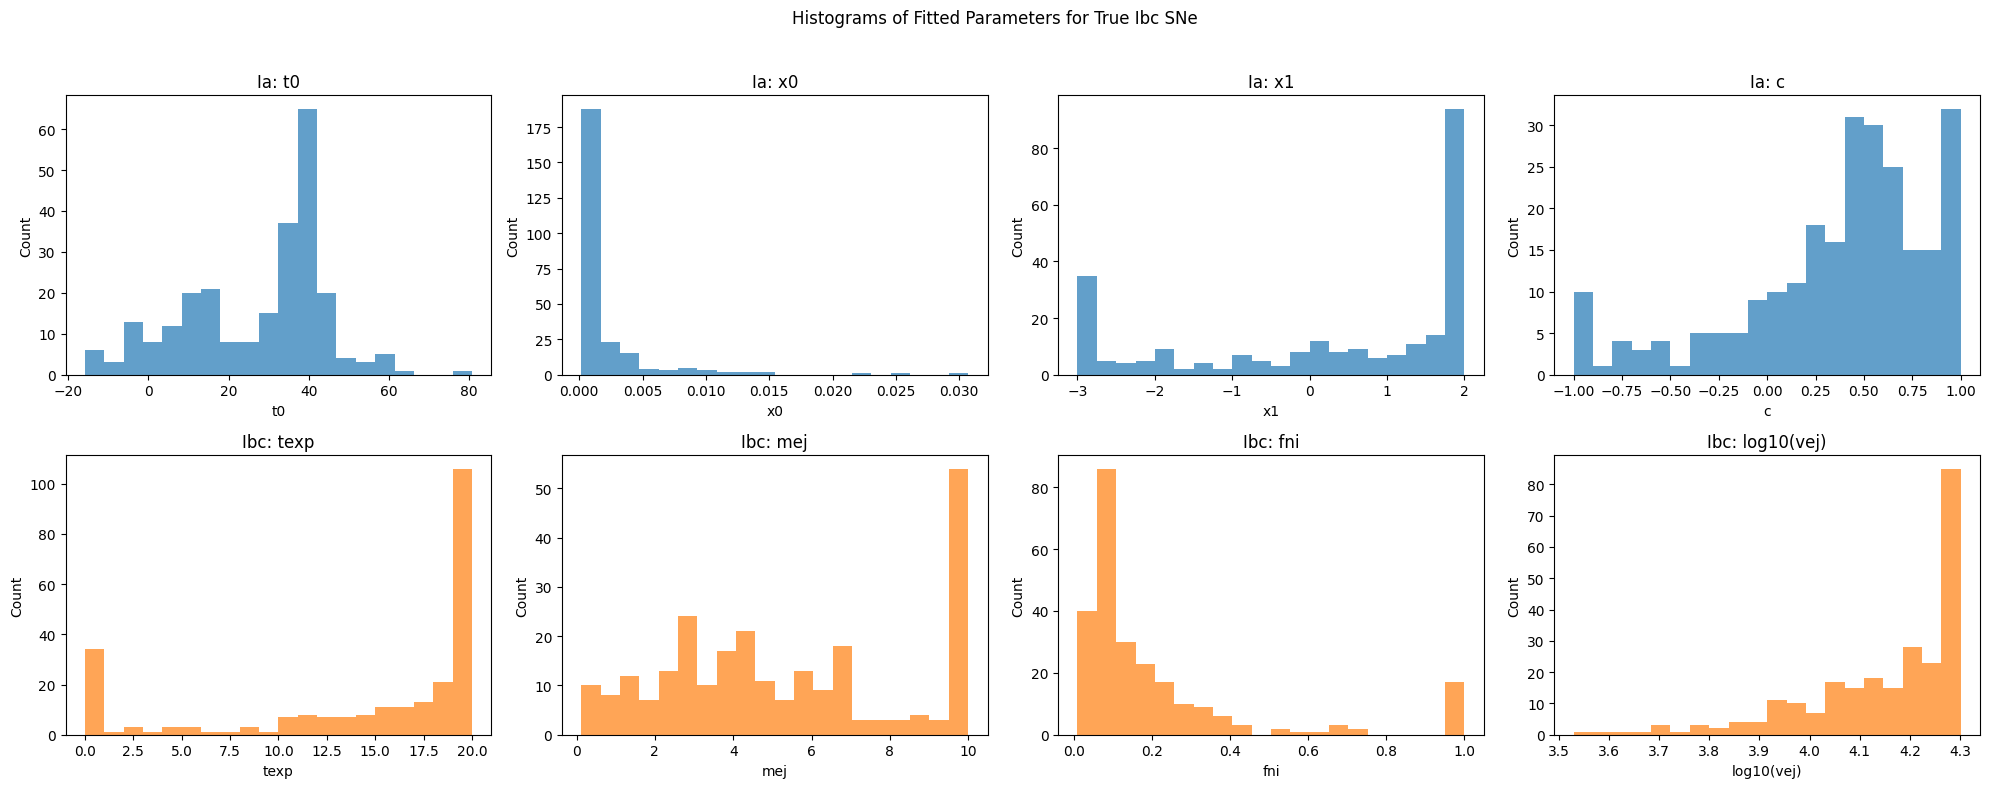

In [27]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [100]:
from os import walk

f = []
d = []
# directory ="transients_spec_group/"
directory ="snapi_sne_Ia/"
for (dirpath, dirnames, filenames) in walk(directory):
    f.extend(filenames)
    d.extend(dirnames)
    break


In [103]:
lcs = []
types = []
redshifts = []
for i in range(len(d)):
    # print(d[i])
    lc = read_feather_file(directory + d[i] + "/_photometry/_ts.feather")
    sn_type, redshift = read_meta_file(directory + d[i] + "/meta.dill")
    # print(sn_type, redshift)
    types.append(sn_type)
    lcs.append(lc)
    redshifts.append(redshift)

pyarrow.Table
filt_center: double
filt_width: double
filter: string
flux: double
flux_error: double
mag: double
mag_error: double
upper_limit: bool
zeropoint: double
mjd: timestamp[ns]
----
filt_center: [[6366.38,4746.48,6366.38,4746.48,6366.38,...,6366.38,6366.38,6366.38,6366.38,6366.38]]
filt_width: [[1553.43,1317.15,1553.43,1317.15,1553.43,...,1553.43,1553.43,1553.43,1553.43,1553.43]]
filter: [["ZTF_r","ZTF_g","ZTF_r","ZTF_g","ZTF_r",...,"ZTF_r","ZTF_r","ZTF_r","ZTF_r","ZTF_r"]]
flux: [[33.25370634886309,29.544710331051796,28.316544361901695,26.43380786583619,23.946376536194467,...,57.57584571740819,45.48205912322606,45.864863205596116,64.54160821245819,63.48701915234767]]
flux_error: [[null,null,null,null,null,...,15.792289455632359,null,11.868663944497968,13.585445907933297,10.321838040223405]]
mag: [[null,null,null,null,null,...,19.499399185180664,null,19.746299743652344,19.37540054321289,19.393287658691406]]
mag_error: [[null,null,null,null,null,...,0.29780301451683044,null,0.28

KeyError: 'Field "phase" does not exist in schema'

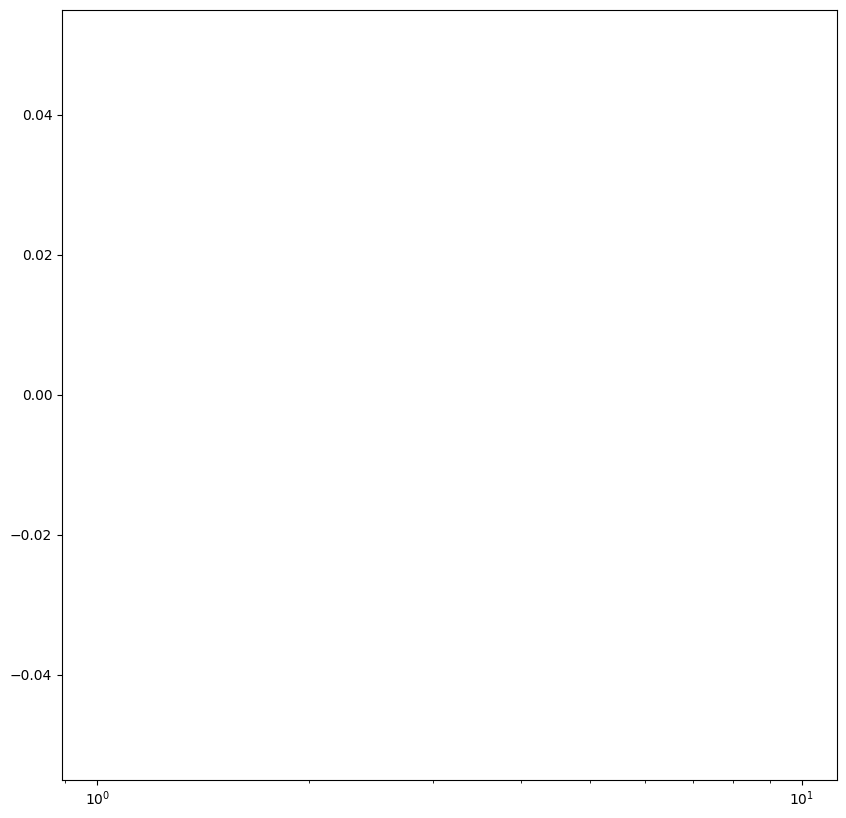

In [98]:
fig = plt.figure(figsize=(10,10))

unique_types, counts = np.unique(types, return_counts=True)

plt.barh(unique_types, counts)
plt.xscale('log')

In [91]:
types

[]

In [17]:
acceptable_types = ['SN Ia', 'SN Ib/c', "SN Ic-BL", "SN Ic", "SN Ib"]
ibc_types = ['SN Ib/c', "SN Ic-BL", "SN Ic", "SN Ib"]

acceptable_indexes = [i for i in range(len(types)) if types[i] in acceptable_types]
[counts[i] for i in [list(unique_types).index(t) for t in acceptable_types]]

[5467, 22, 67, 142, 129]

In [54]:
indexes_to_use = np.concatenate((np.random.choice([i for i in range(len(types)) if types[i] == 'SN Ia'], 360), [i for i in range(len(types)) if types[i] in ibc_types]))
len(indexes_to_use)

720

In [55]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
        # if self.true_class == 'ia':
        #     self.true_params = {key:true_dict[key] for key in self.ia_keys}
        # elif self.true_class == 'ibc':
        #     self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        # else:
        #     raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [70]:
sn_objects = []
indexes_used = []
for i in np.random.choice(indexes_to_use, 10, replace=False):
    try:
        ia_result, ia_fitted_model = fit_ia(redshifts[i], [lcs[i]])
        ibc_result, ibc_fitted_model = fit_ibc(redshifts[i], [lcs[i]])
        sn_obj = real_SN(types[i], redshifts[i])
        sn_obj.fit_as_ia(sncosmo.flatten_result(ia_result))
        sn_obj.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        sn_objects.append(sn_obj)
        indexes_used.append(i)
    except Exception as e:
        print(f"Exception for index {i}: {e}")
    


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Exception for index 4454: `y` must contain only finite values.
Trying again...
Exception for index 5772: `y` must contain only finite values.


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Exception for index 1893: `y` must contain only finite values.


In [71]:
len(sn_objects)

7

In [27]:
sn_objects[1].ia_fit, sn_objects[1].ibc_fit, sn_objects[1].true_redshift, sn_objects[1].true_class

({'t0': 37.835784259614705,
  'x0': 3.455249723091858e-06,
  'x1': -0.34437177743839364,
  'c': 0.26126348365584573},
 {'texp': 19.999999999996504,
  'mej': 0.5567454760963556,
  'fni': 0.010000000000016399,
  'vej': 19999.9999953328},
 0.038,
 'SN Ia')

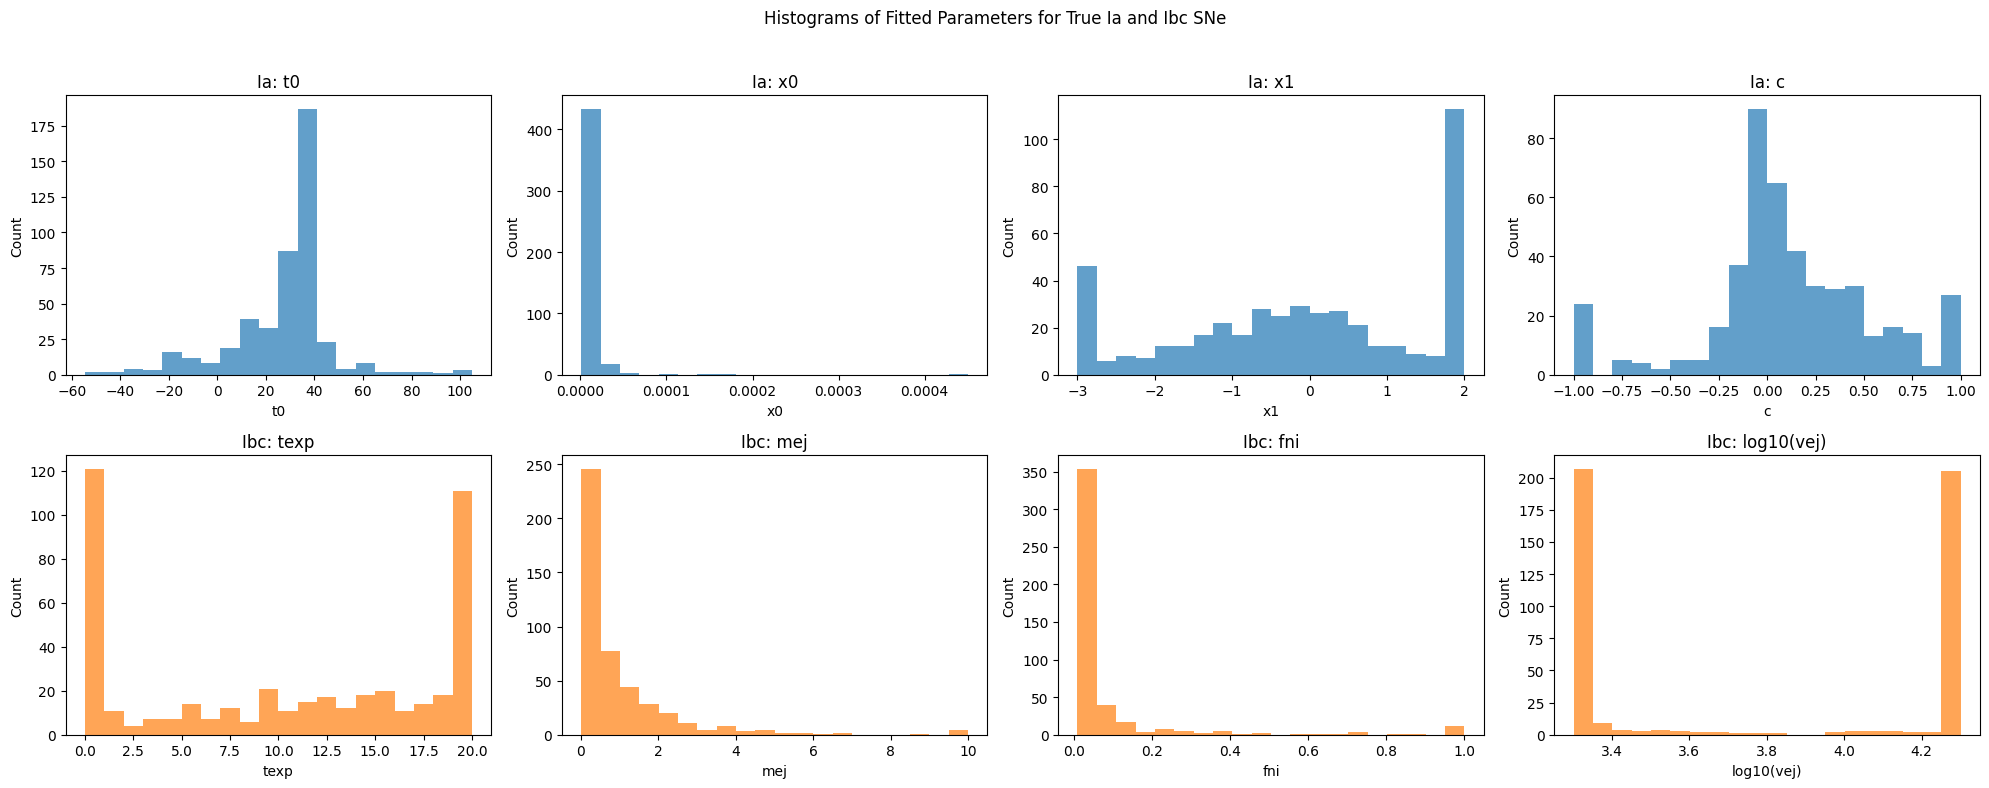

In [28]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

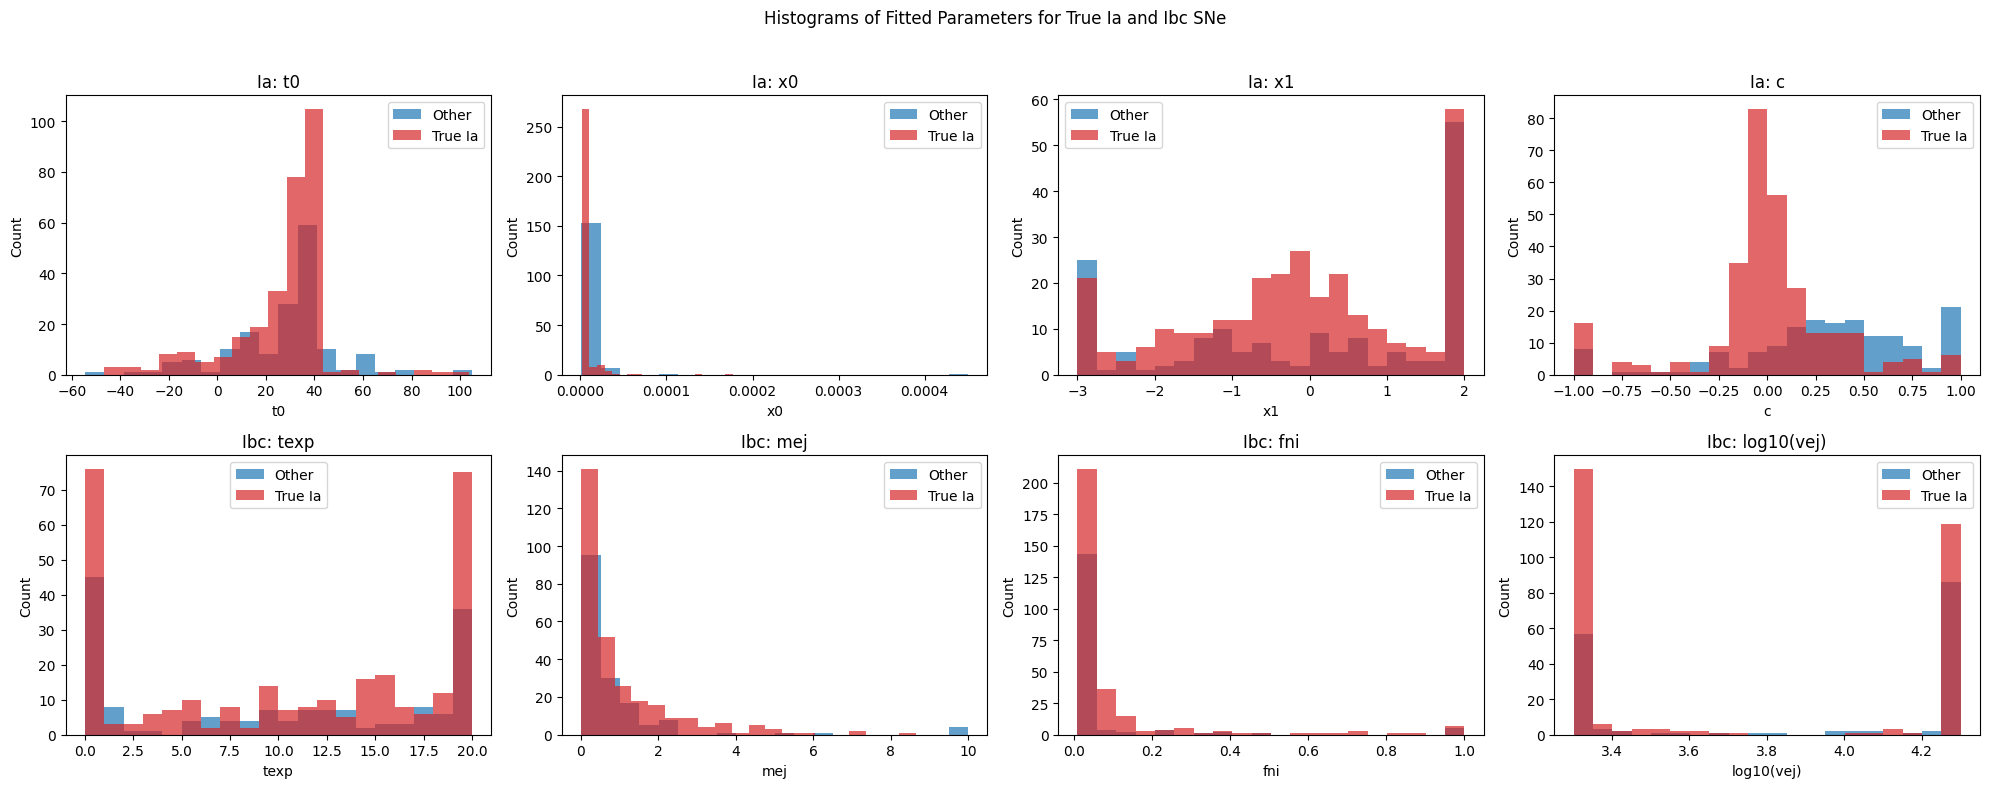

In [29]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values_ia = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class != 'SN Ia']
    axes[0, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other')
    axes[0, i].hist(values_ia, bins=20, color='tab:red', alpha=0.7, label='True Ia')
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values_ibc = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class != 'SN Ia']
    if param == 'vej':
        values_other = [np.log10(v) for v in values_other if v > 0]
        values_ibc = [np.log10(v) for v in values_ibc if v > 0]
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other')
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia')
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other')
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia')
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [30]:
sum([sn.true_class == 'SN Ia' for sn in sn_objects])

295

In [31]:
np.unique([sn.true_class for sn in sn_objects])

array(['SN Ia', 'SN Ib', 'SN Ib/c', 'SN Ic', 'SN Ic-BL'], dtype='<U8')

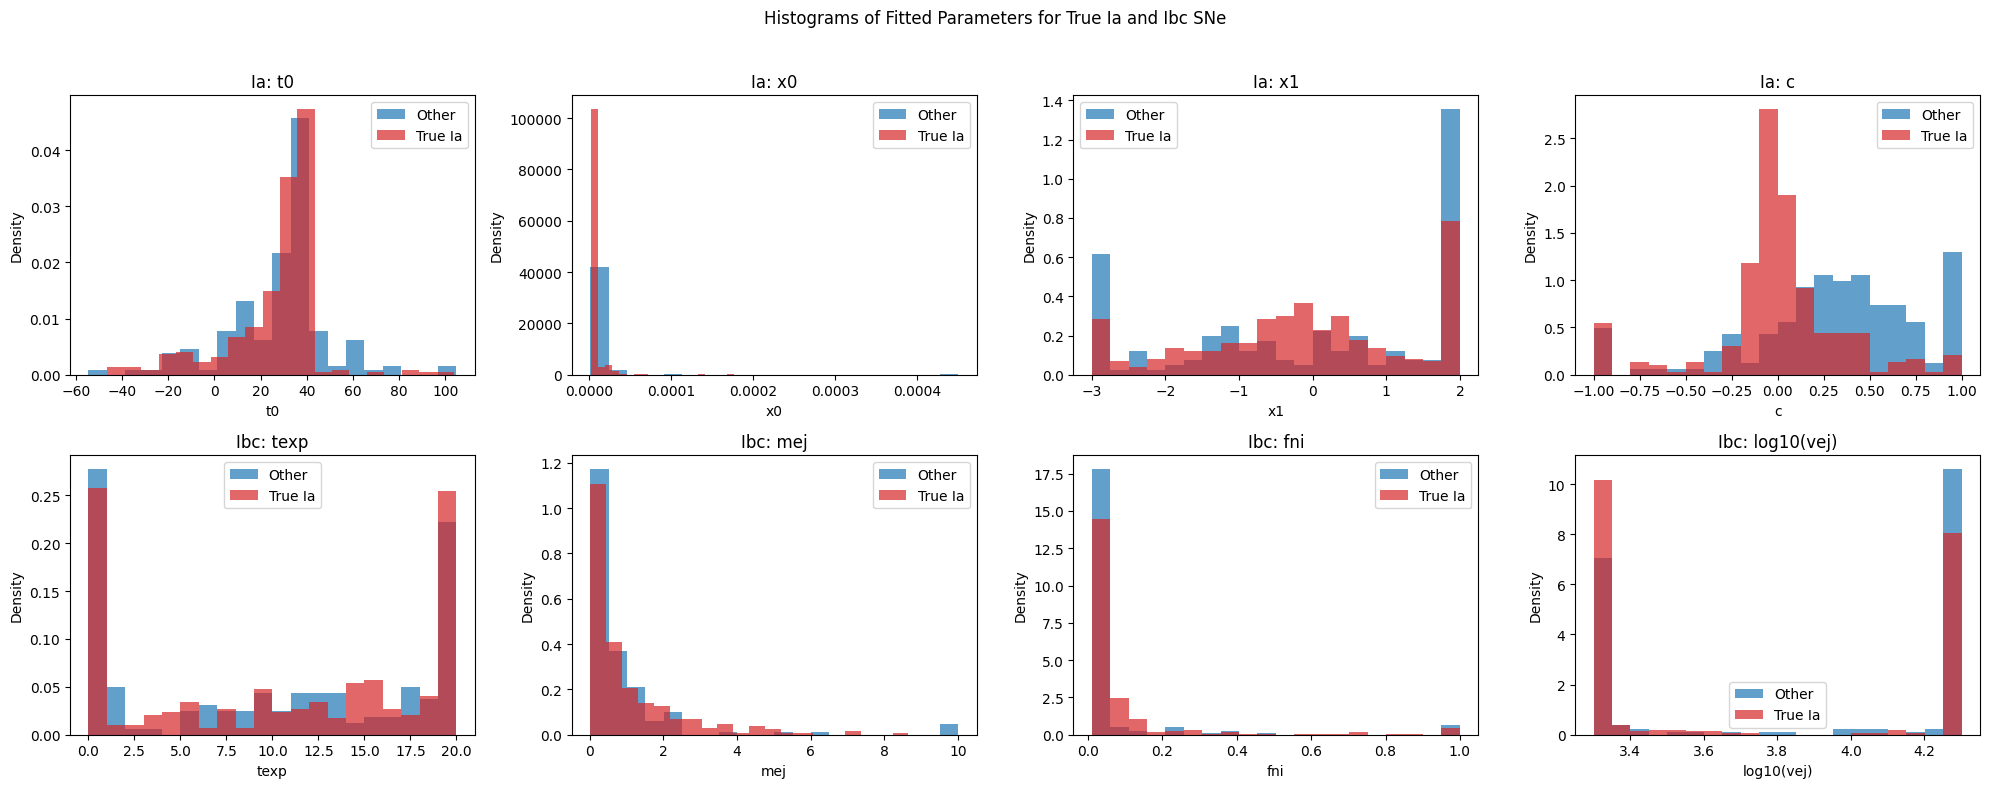

In [32]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values_ia = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class != 'SN Ia']
    axes[0, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other', density=True)
    axes[0, i].hist(values_ia, bins=20, color='tab:red', alpha=0.7, label='True Ia', density=True)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Density")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values_ibc = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class != 'SN Ia']
    if param == 'vej':
        values_other = [np.log10(v) for v in values_other if v > 0]
        values_ibc = [np.log10(v) for v in values_ibc if v > 0]
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other', density=True)
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia', density=True)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other', density=True)
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia', density=True)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Density")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [33]:
np.savez("fitted_sne_real_121725.npz", ia=[sn for sn in sn_objects if sn.true_class == 'SN Ia'], ibc=[sn for sn in sn_objects if sn.true_class != 'SN Ia'])

In [58]:
len(sn_objects), len(lcs), len(redshifts), len(indexes_to_use), len(indexes_used)

(6, 8301, 8301, 720, 6)

1 SN Ic 0.0275
[17.847102247886124, 0.6565173566299105, 0.0100000012532224, 19999.99795615618]


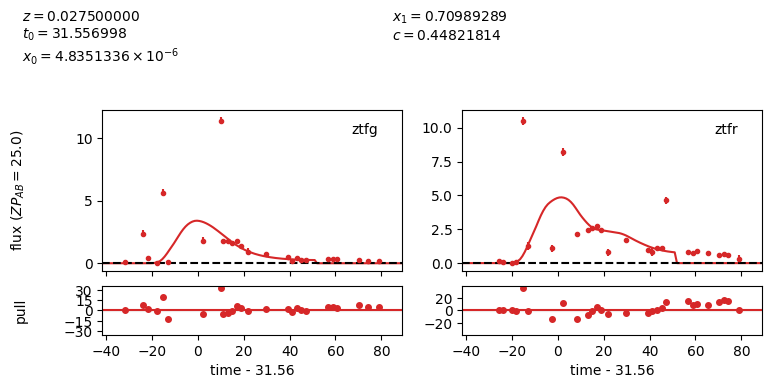

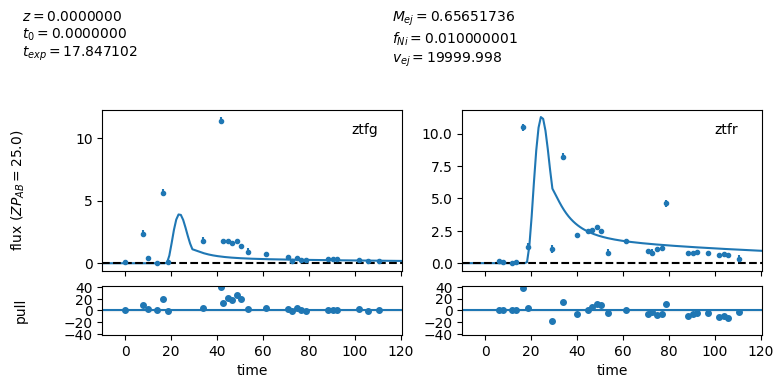

6 SN Ic 0.031
[18.089710127536012, 0.4836862865499315, 0.010000906344642993, 19999.90892641844]


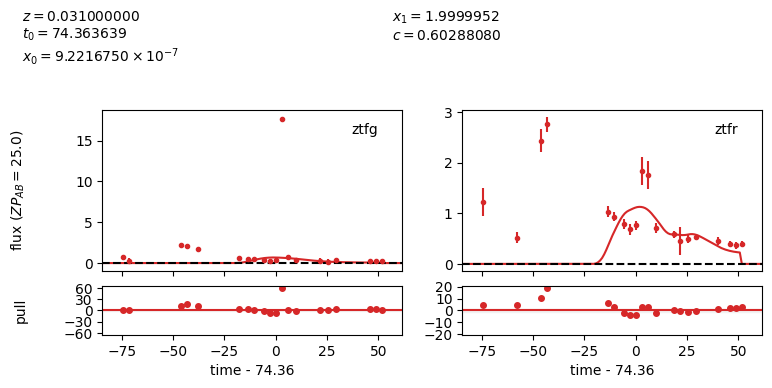

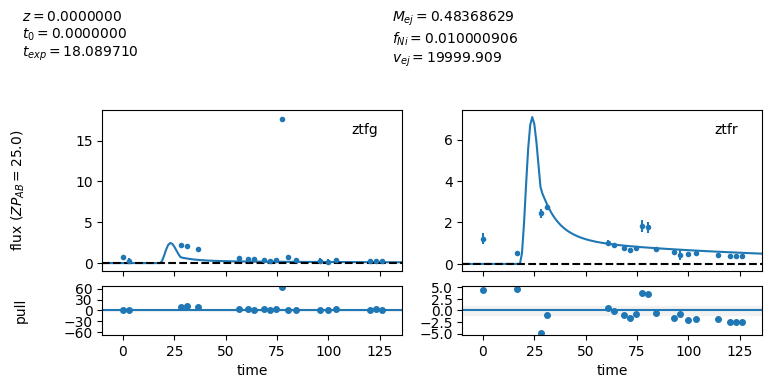

0 SN Ia 0.04
[3.805883722323572e-11, 0.1919747033347422, 0.012798074040704759, 2000.0000000071793]


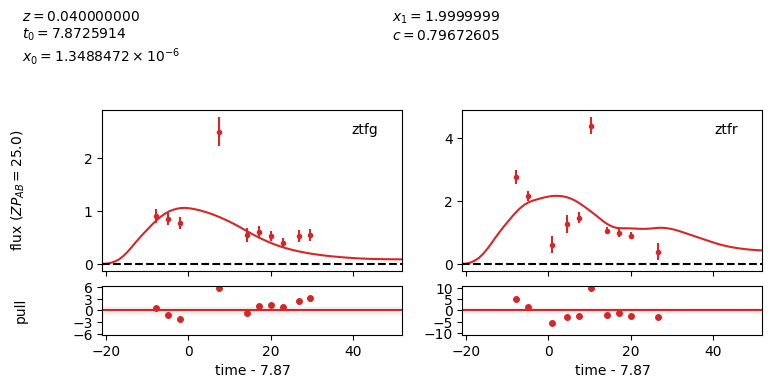

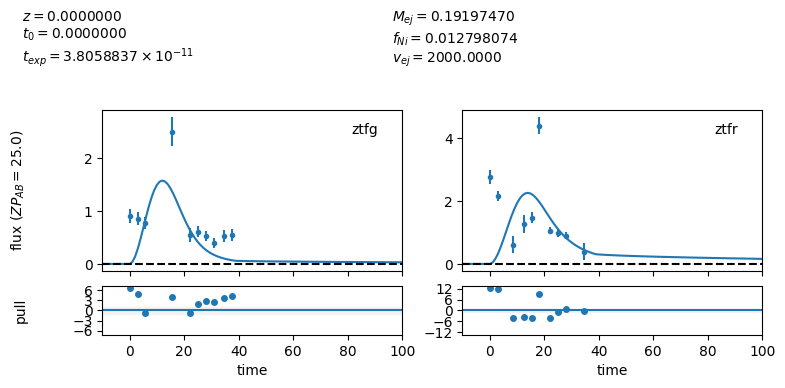

2 SN Ia 0.079
[4.0753503168693486e-07, 5.658536188144334, 0.01081686277618496, 19999.999535587736]


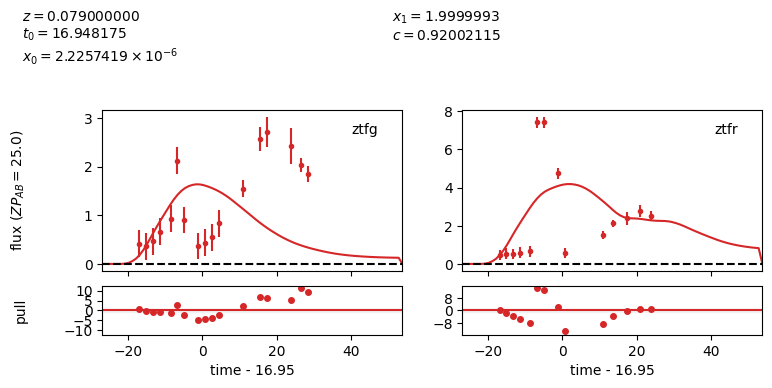

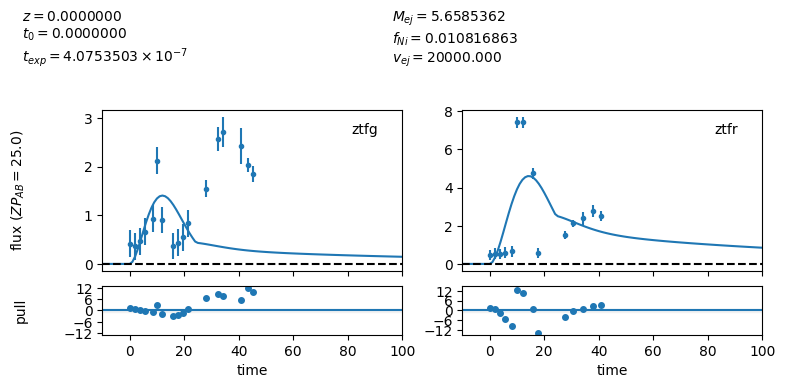

4 SN Ic 0.05
[18.243060587138118, 0.636606994918698, 0.012992686152697566, 2000.0000000010546]


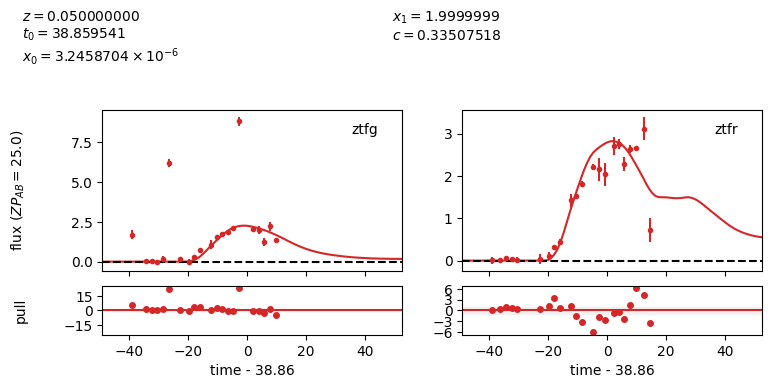

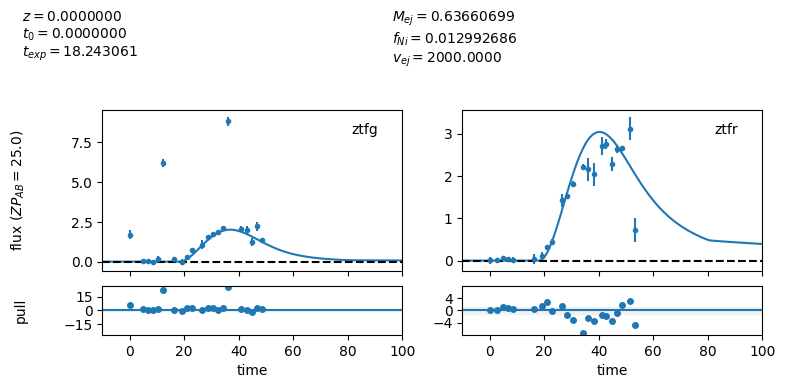

In [74]:
num_to_plot = 5
indices = np.random.choice(len(sn_objects), num_to_plot, replace=False)
for i, idx in enumerate(indices):
    sn = sn_objects[idx]
    print(idx, sn.true_class, sn.true_redshift)

    lc = lcs[indexes_used[idx]]
    z = redshifts[indexes_used[idx]]

    # Fit as Ia
    ia_model = sncosmo.Model(source='salt2')
    ia_model.set(z=z, **sn.ia_fit)
    sncosmo.plot_lc(lc, model=ia_model,  color='tab:red', label='Ia fit')
    # axes[i, 0].set_title(f"SN {idx} ({sn.true_class}) - Ia fit")

    print([sn.ibc_fit[k] for k in sn.ibc_keys[1:]])

    # Fit as Ibc
    arnett_source = ArnettSource(times, wavelengths, z, params=[sn.ibc_fit[k] for k in sn.ibc_keys[1:]])
    ibc_model = sncosmo.Model(source=arnett_source)
    sncosmo.plot_lc(lc, model=ibc_model, color='tab:blue', label='Ibc fit')
    # axes[i, 1].set_title(f"SN {idx} ({sn.true_class}) - Ibc fit")
    plt.show()

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


10


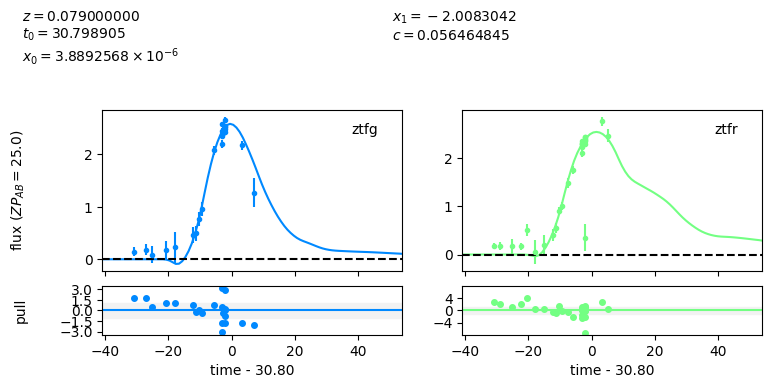

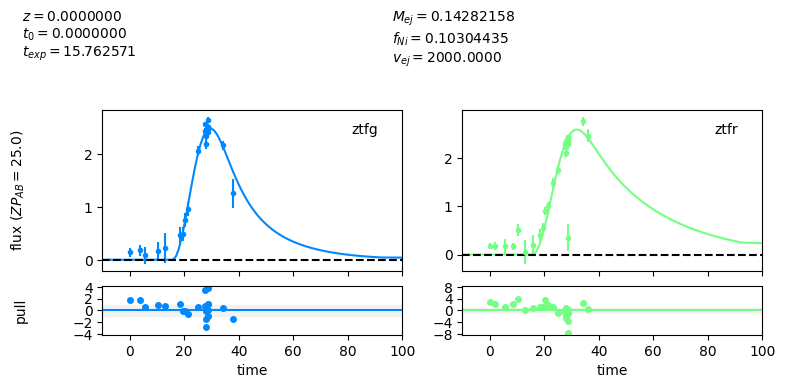

In [65]:
idx= 5
lc = lcs[indexes_used[idx]]
z = redshifts[indexes_used[idx]]

result, fitted_model = fit_ia(z, [lc])
sncosmo.plot_lc(lc, model=fitted_model);

print(guess_texp(lc))
result, fitted_model = fit_ibc(z, [lc], texp_guess = 20)
sncosmo.plot_lc(lc, model=fitted_model);

In [ ]:
import os
import re

def get_redshifts_from_directory(directory_path):
    """
    Extract redshift values from CSV filenames in the specified directory.
    
    Expected filename format: "ZTF18abfzhct_SN-Ic_0.04_bts.csv"
    where 0.04 is the redshift.
    
    Parameters:
    -----------
    directory_path : str
        Path to directory containing the CSV files
        
    Returns:
    --------
    dict : Dictionary with filenames as keys and redshifts as values
    """
    redshift_dict = {}
    
    # Get all CSV files in the directory
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('_bts.csv')]
    
    # Pattern to extract redshift: decimal number before _bts.csv
    # Format: anything_SN-Type_REDSHIFT_bts.csv
    pattern = r'_SN-[IVabc]+_(\d+\.?\d*)_bts\.csv'
    
    for filename in csv_files:
        match = re.search(pattern, filename)
        if match:
            redshift = float(match.group(1))
            redshift_dict[filename] = redshift
        else:
            print(f"Warning: Could not extract redshift from {filename}")
    
    return redshift_dict

# Use the function
directory_path = "ibc_sims_to_fit"
redshift_dict = get_redshifts_from_directory(directory_path)

# Display results
print(f"Found {len(redshift_dict)} files with redshift information:\n")
for filename, redshift in sorted(redshift_dict.items(), key=lambda x: x[1]):
    print(f"{filename}: z = {redshift}")